# Création de cartes
### Visualisation des ventes par département

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
df_factures = pd.read_excel("data/Factures_solupharm.xlsx", sheet_name="factures")
df_pharma   = pd.read_excel("data/Factures_solupharm.xlsx", sheet_name="Pharmacies")
df_produit  = pd.read_excel("data/Factures_solupharm.xlsx", sheet_name="Produits")
df_sector   = pd.read_excel("data/Factures_solupharm.xlsx", sheet_name="Sectorisation")

df_factures["date_fac"] = pd.to_datetime(df_factures['date_fac'], format='%Y%m%d')
df_sector = df_sector.rename(columns={'UGA': 'uga'})

### Lecture du fichier GeoJson pour récupérer les formes des départements
Définition des codes de départements en métropole et en Ile-de-France

In [4]:
CODES_METROPOLE = [f"{i:02d}" for i in range(1, 96)]
CODE_IDF = ["77", "92", "94", "75", "93", "95", "78", "91"]

gdf_dept = gpd.read_file("data/georef-france-departement-millesime.geojson")
gdf_dept = gdf_dept[gdf_dept['dep_code'].isin(CODES_METROPOLE)]
gdf_dept = gdf_dept.rename(columns={"dep_code" : "code_dept"})
gdf_dept.head(1)

Skipping field dep_status: unsupported OGR type: 5


,geo_point_2d,year,reg_code,reg_name,code_dept,dep_current_code,dep_name,dep_name_upper,dep_name_lower,dep_area_code,dep_type,dep_siren_code,dep_is_ctu,geometry
0,"{ ""lon"": -0.78394966333495697, ""lat"": 43.96574...",2021,75,Nouvelle-Aquitaine,40,40,Landes,LANDES,landes,FXX,département,224000018,Non,"POLYGON ((-1.25358 44.46751, -1.26801 44.37405..."


### Création du dataframe contenant les factures et les départements

In [13]:
df_temp = df_pharma.copy()
df_temp = df_temp[~df_temp["cp"].isna()]

df_temp['cp'] = df_temp['cp'].astype(int) # Enlève le .0 des float
df_temp['cp'] = df_temp['cp'].astype(str) 
# Rempli les code départements de 0 jusqu'à atteindre 5 caractères 1214 -> 01241
df_temp['cp'] = df_temp['cp'].str.zfill(5) 

df_temp['code_dept'] = df_temp['cp'].str[:2]
df_temp = df_temp[df_temp['code_dept'].isin(CODES_METROPOLE)]


df = df_factures.merge(
    df_temp[['pharma_cip', 'code_dept', 'cp']],
    on='pharma_cip', how='left'
)

df = df[~df['code_dept'].isna()]

# Filtre France métropolotaine 
df.head(5)

,no_fac,date_fac,no_cde,code_pharmacie,pharma_cip,groupement,code_produit,cip13,qte_facturee,qte_gratuite,remise,prix_net_ht,ca_total_ht,no_lot,marche,tiers,code_dept,cp
0,591121693,2025-04-11,3.232051e+09,58,2000238,NaN,4288995.0,3401551533691,1,0,35,12,12,7.520016e+09,NaN,DIRECT,01,01250
1,591121693,2025-04-11,3.232051e+09,58,2000238,NaN,8999534.0,3664951000075,12,1,35,10,121,NaN,NaN,DIRECT,01,01250
2,591121693,2025-04-11,3.232051e+09,58,2000238,NaN,8999897.0,3518074343017,3,0,30,20,61,1.735550e+05,NaN,DIRECT,01,01250
3,591121693,2025-04-11,3.232051e+09,58,2000238,NaN,4288995.0,3401551533691,5,1,35,12,59,7.520016e+09,NaN,DIRECT,01,01250
4,591121692,2025-04-11,3.232051e+09,93,2005357,NaN,8999538.0,3518073923012,6,0,30,21,124,1.740490e+05,NaN,DIRECT,01,01100


### Récupération des données démographiques des départements

In [6]:
df_pop = pd.read_csv('data/donnees_departements.csv', sep=';')
df_pop = df_pop.rename(columns={"DEP" : "code_dept", "PTOT": "population_totale"})

# Filtre la Corse regroupe 2A et 2B ensembles 
df_pop['code_dept'] = df_pop['code_dept'].apply(lambda x: '20' if x in ['2A', '2B'] else x)
df_pop = df_pop.groupby(by=["code_dept"]).sum().reset_index()

df_pop = df_pop[['code_dept', "population_totale"]]
# Filtre
df_pop = df_pop[df_pop['code_dept'].isin(CODES_METROPOLE)]
df_pop.head(5)

,code_dept,population_totale
0,01,686804
1,02,536985
2,03,343338
3,04,171621
4,05,145993


### Création des dataframe pour l'année 2023 et 2024
Les datframes vont de février à février

In [7]:
start_date = df['date_fac'].min()


end_date_2023 = start_date + pd.DateOffset(years=1)
start_date_2024 = end_date_2023 + pd.Timedelta(days=1)
end_date_2024 = start_date_2024 + pd.DateOffset(years=1)

df2023 = df[(df['date_fac'] >= start_date) & (df['date_fac'] <= end_date_2023)]
df2024 = df[(df['date_fac'] >= start_date_2024) & (df['date_fac'] <= end_date_2024)]

## Ventes totales par département

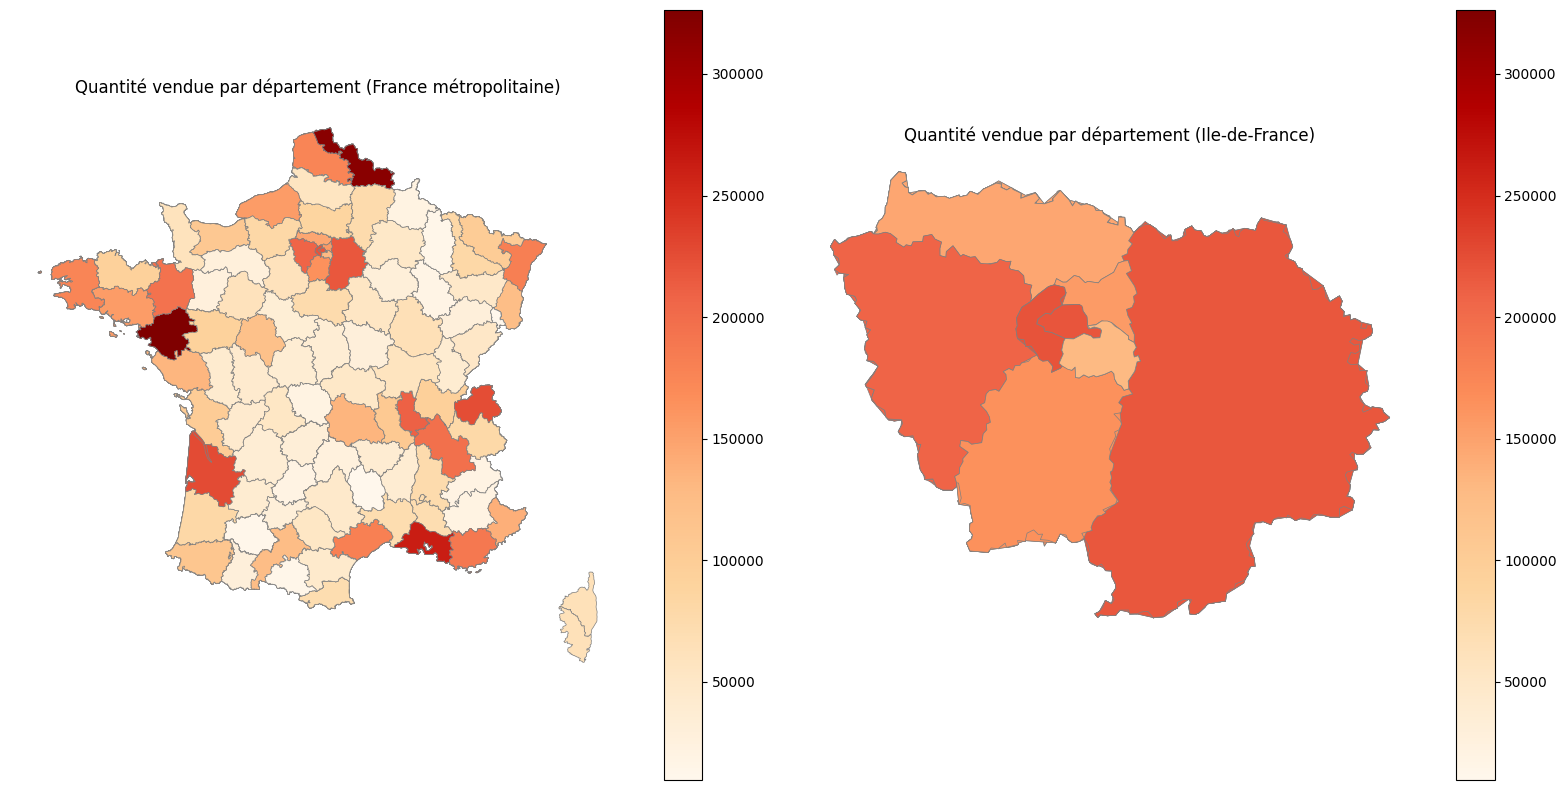

In [8]:
sales_by_dept = (
    df.groupby('code_dept')['qte_facturee']
      .sum()
      .reset_index(name='sales')
)

# Merge géo + ventes pour la carte 1
gdf1 = (
    gdf_dept
      .merge(sales_by_dept, on="code_dept", how='left')
      .fillna({'sales': 0})
)

# Merge géo + ventes pour la carte 2
gdf2 = (
    gdf_dept[gdf_dept['code_dept'].isin(CODE_IDF)]
      .merge(sales_by_dept, on="code_dept", how='left')
      .fillna({'sales': 0})
)

# Double figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Echelle commune de couleur
vmin = min(gdf1['sales'].min(), gdf2['sales'].min())
vmax = max(gdf1['sales'].max(), gdf2['sales'].max())

# Carte #1 : volume brut de ventes (métropole uniquement)
gdf1.plot(
    column='sales',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax1,
    vmin=vmin,
    vmax=vmax 
)
ax1.set_title("Quantité vendue par département (France métropolitaine)")
ax1.axis('off')

# Carte #2 : zoom Ile-de-France
gdf2.plot(
    column='sales',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax2,
    vmin=vmin,
    vmax=vmax 
)
ax2.set_title("Quantité vendue par département (Ile-de-France)")
ax2.axis('off')


plt.tight_layout()  # Ajuste les espacements pour éviter que les éléments se chevauchent
plt.show()

## Vente totale par habitant

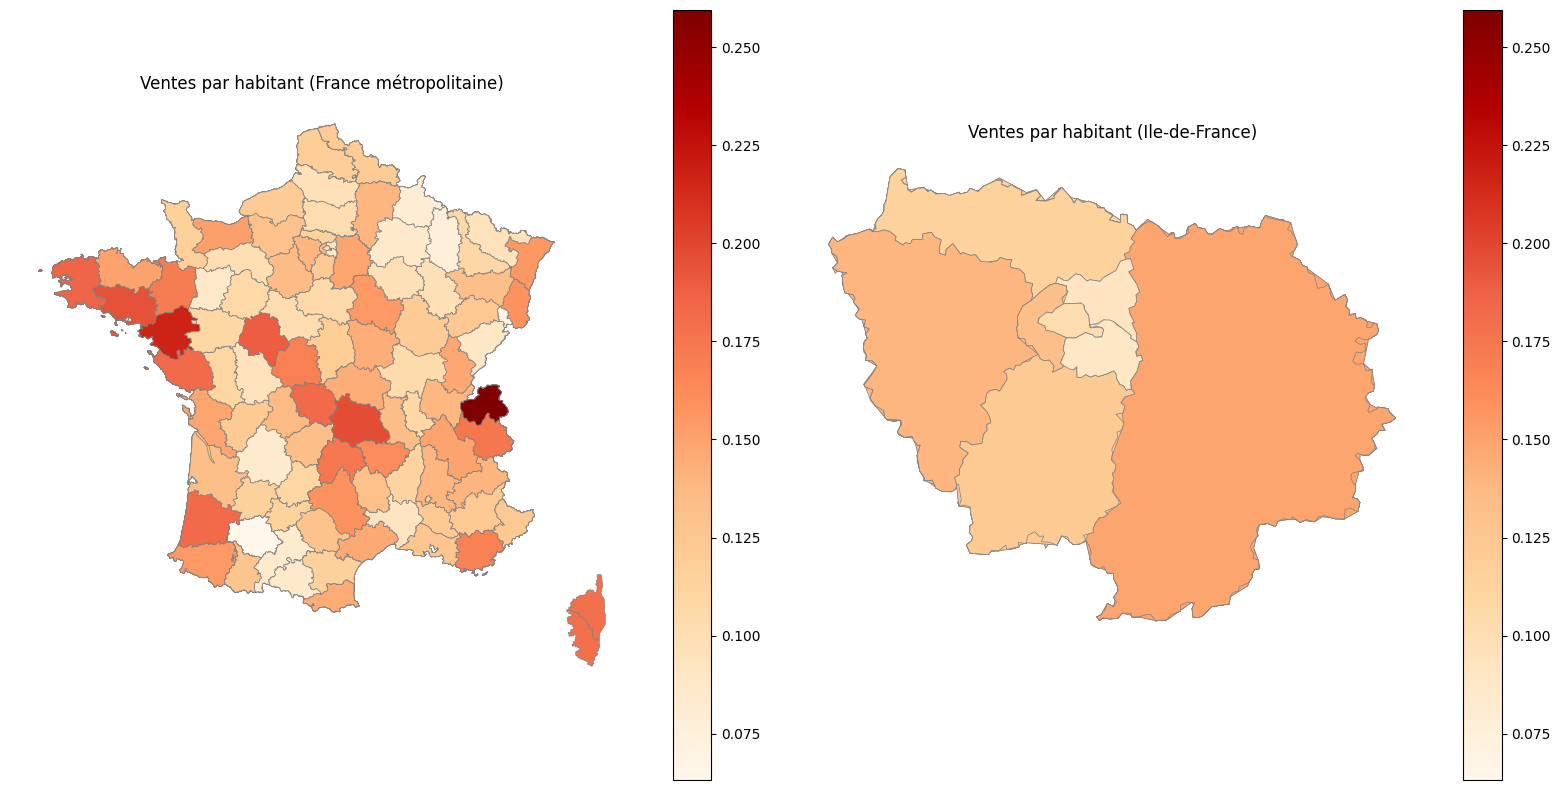

In [9]:
df_pop_sales = (
    sales_by_dept
      .merge(df_pop[['code_dept','population_totale']], on='code_dept', how='left')
      .fillna({'population_totale': 1})
)
df_pop_sales['sales_per_capita'] = df_pop_sales['sales'] / df_pop_sales['population_totale']

# Merge géo + ventes par habitant
gdf3 = (
    gdf_dept
      .merge(df_pop_sales[['code_dept','sales_per_capita']], on='code_dept', how='left')
      .fillna({'sales_per_capita': 0})
)

# Merge géo + ventes par habitant pour Ile-de-France
gdf4 = (
    gdf_dept[gdf_dept['code_dept'].isin(CODE_IDF)]
      .merge(df_pop_sales[['code_dept','sales_per_capita']], on='code_dept', how='left')
      .fillna({'sales_per_capita': 0})
)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

vmin = min(gdf3['sales_per_capita'].min(), gdf4['sales_per_capita'].min())
vmax = max(gdf3['sales_per_capita'].max(), gdf4['sales_per_capita'].max())

# Carte #1 : ventes par habitant (métropole uniquement)
gdf3.plot(
    column='sales_per_capita',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax1,
    vmin=vmin,
    vmax=vmax 
)
ax1.set_title("Ventes par habitant (France métropolitaine)")
ax1.axis('off')

# Carte #2 : ventes par habitant (Ile-de-France uniquement)
gdf4.plot(
    column='sales_per_capita',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax2,
    vmin=vmin,
    vmax=vmax 
)
ax2.set_title("Ventes par habitant (Ile-de-France)")
ax2.axis('off')


plt.tight_layout()
plt.show()

## Vente totale par pharmacie

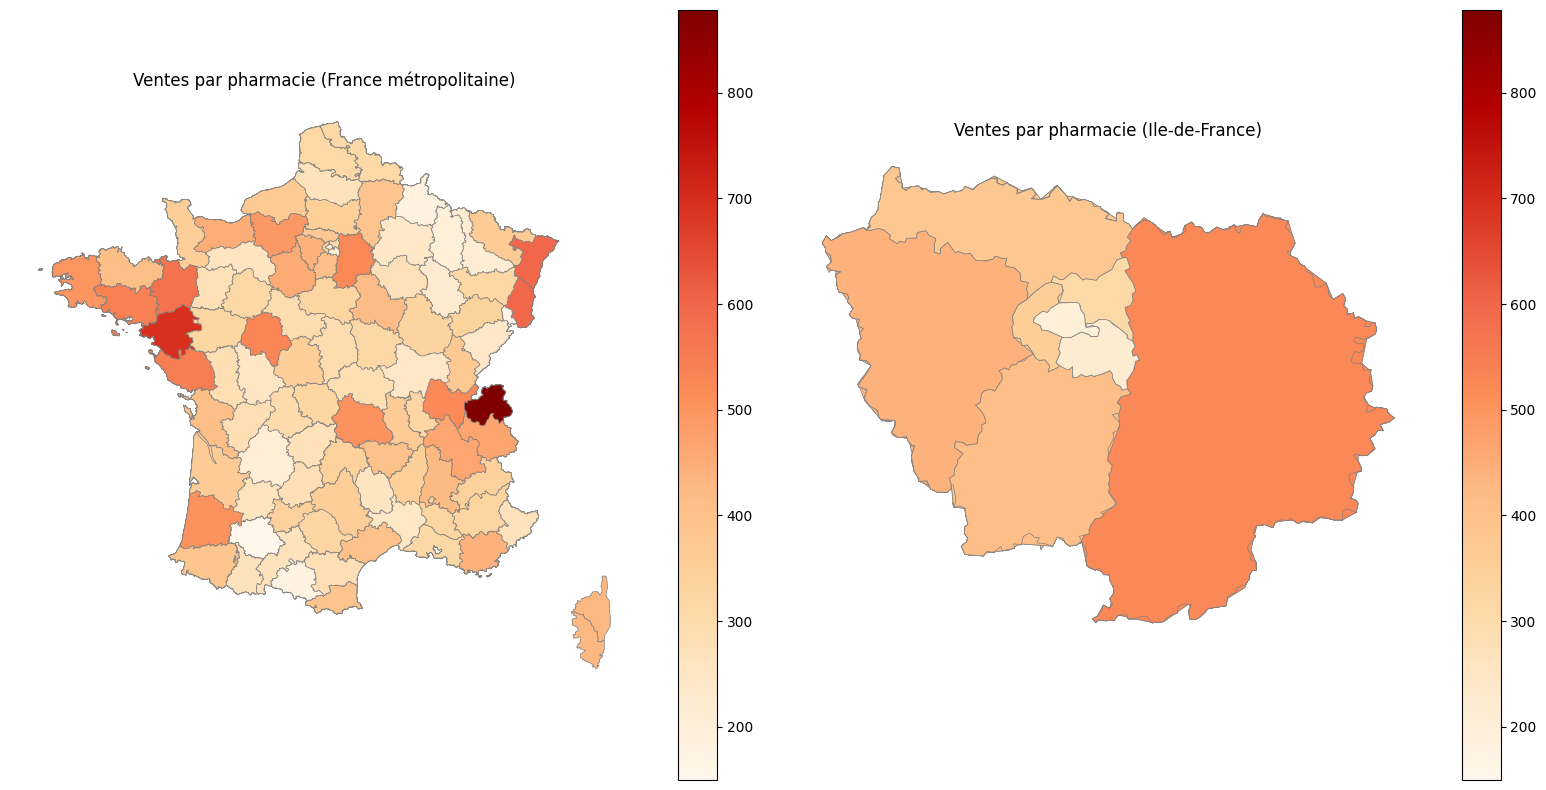

In [ ]:
pharm_count = (
    df_temp
      .groupby('code_dept')['pharma_cip']
      .nunique()
      .reset_index(name='n_pharmacies')
)

df_pharm_sales = (
    sales_by_dept
      .merge(pharm_count, on='code_dept', how='left')
      .fillna({'n_pharmacies': 1})
)
df_pharm_sales['sales_per_pharmacy'] = df_pharm_sales['sales'] / df_pharm_sales['n_pharmacies']

gdf5 = (
    gdf_dept
      .merge(df_pharm_sales[['code_dept','sales_per_pharmacy']], on='code_dept', how='left')
      .fillna({'sales_per_pharmacy': 0})
)

gdf6 = (
    gdf_dept[gdf_dept['code_dept'].isin(CODE_IDF)]
      .merge(df_pharm_sales[['code_dept','sales_per_pharmacy']], on='code_dept', how='left')
      .fillna({'sales_per_pharmacy': 0})
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
vmin = min(gdf5['sales_per_pharmacy'].min(), gdf6['sales_per_pharmacy'].min())
vmax = max(gdf5['sales_per_pharmacy'].max(), gdf6['sales_per_pharmacy'].max())


# Carte #5 : ventes par pharmacie (métropole uniquement)
gdf5.plot(
    column='sales_per_pharmacy',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax1,
    vmin=vmin,
    vmax=vmax
)
ax1.set_title("Ventes par pharmacie (France métropolitaine)")
ax1.axis('off')

# Carte #6 : ventes par habitant (Ile-de-France uniquement)
gdf6.plot(
    column='sales_per_pharmacy',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax2,
    vmin=vmin, 
    vmax=vmax  
)
ax2.set_title("Ventes par pharmacie (Ile-de-France)")
ax2.axis('off')


plt.tight_layout()
plt.show()

## Nombre de pharmacie pour 10k habitants

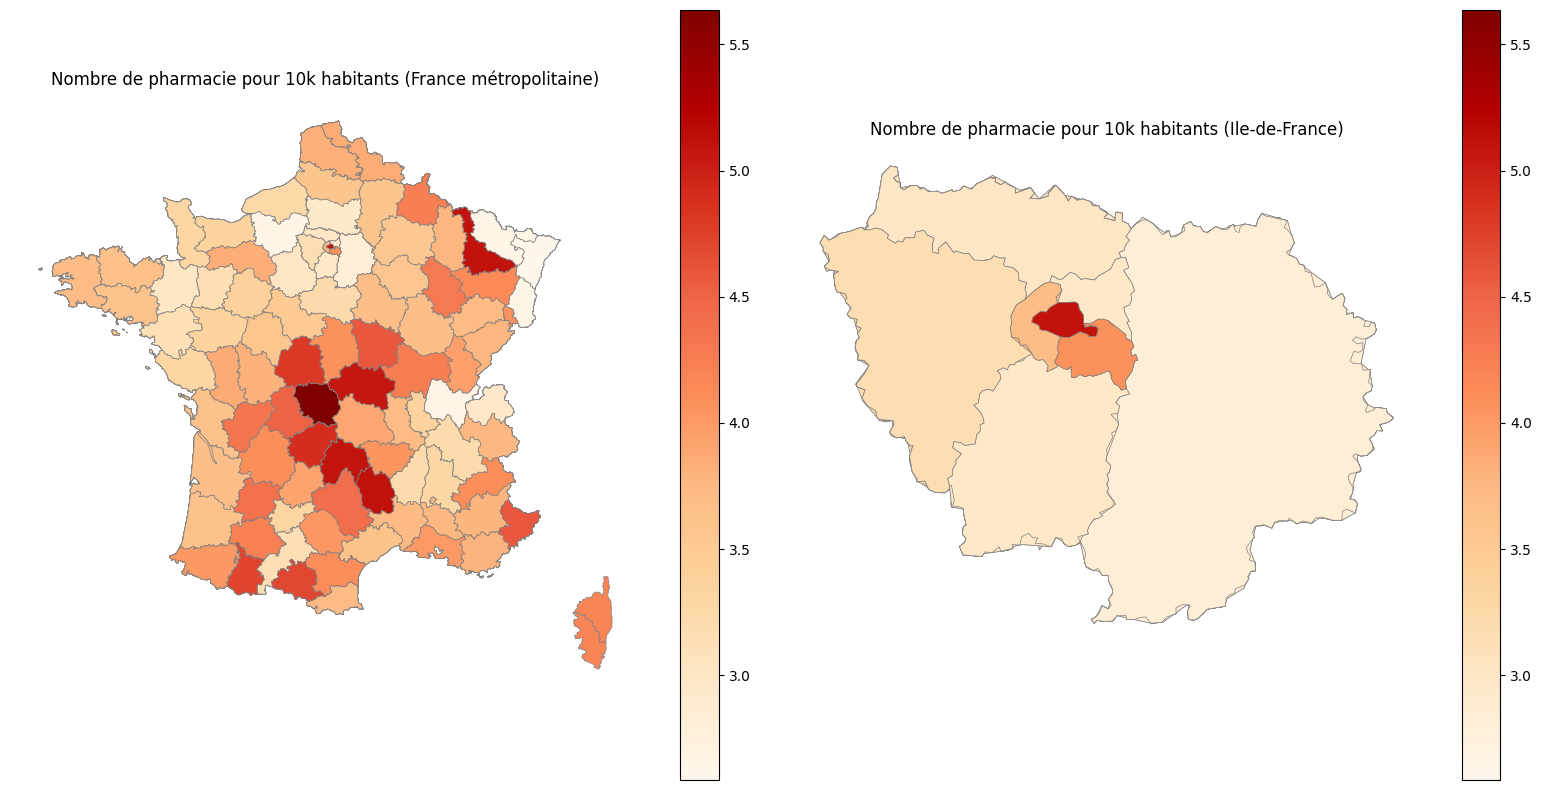

In [ ]:
df_pop_pharma = (
    pharm_count
      .merge(df_pop, on='code_dept', how='left')
      .fillna({'n_pharmacies': 1})
)

df_pop_pharma["pharma_pour_10k"] = (df_pop_pharma["n_pharmacies"] / df_pop_pharma["population_totale"]) * 10000

gdf7 = (
    gdf_dept
      .merge(df_pop_pharma[['code_dept','pharma_pour_10k']], on='code_dept', how='left')
      .fillna({'pharma_pour_10k': 0})
)

gdf8 = (
    gdf_dept[gdf_dept['code_dept'].isin(CODE_IDF)]
      .merge(df_pop_pharma[['code_dept','pharma_pour_10k']], on='code_dept', how='left')
      .fillna({'pharma_pour_10k': 0})
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
vmin = min(gdf7['pharma_pour_10k'].min(), gdf8['pharma_pour_10k'].min())
vmax = max(gdf7['pharma_pour_10k'].max(), gdf8['pharma_pour_10k'].max())

# Carte #7 : Nombre de pharmacies pour 10k habitants (métropole uniquement)
gdf7.plot(
    column='pharma_pour_10k',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax1,
    vmin=vmin,
    vmax=vmax 
)
ax1.set_title("Nombre de pharmacie pour 10k habitants (France métropolitaine)")
ax1.axis('off')

# Carte #8 : Nombre de pharmacies pour 10k habitants (Ile-de-France uniquement)
gdf8.plot(
    column='pharma_pour_10k',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax2,
    vmin=vmin,
    vmax=vmax
)
ax2.set_title("Nombre de pharmacie pour 10k habitants (Ile-de-France)")
ax2.axis('off')


plt.tight_layout()
plt.show()

## Ventes par pharmacie par habitant

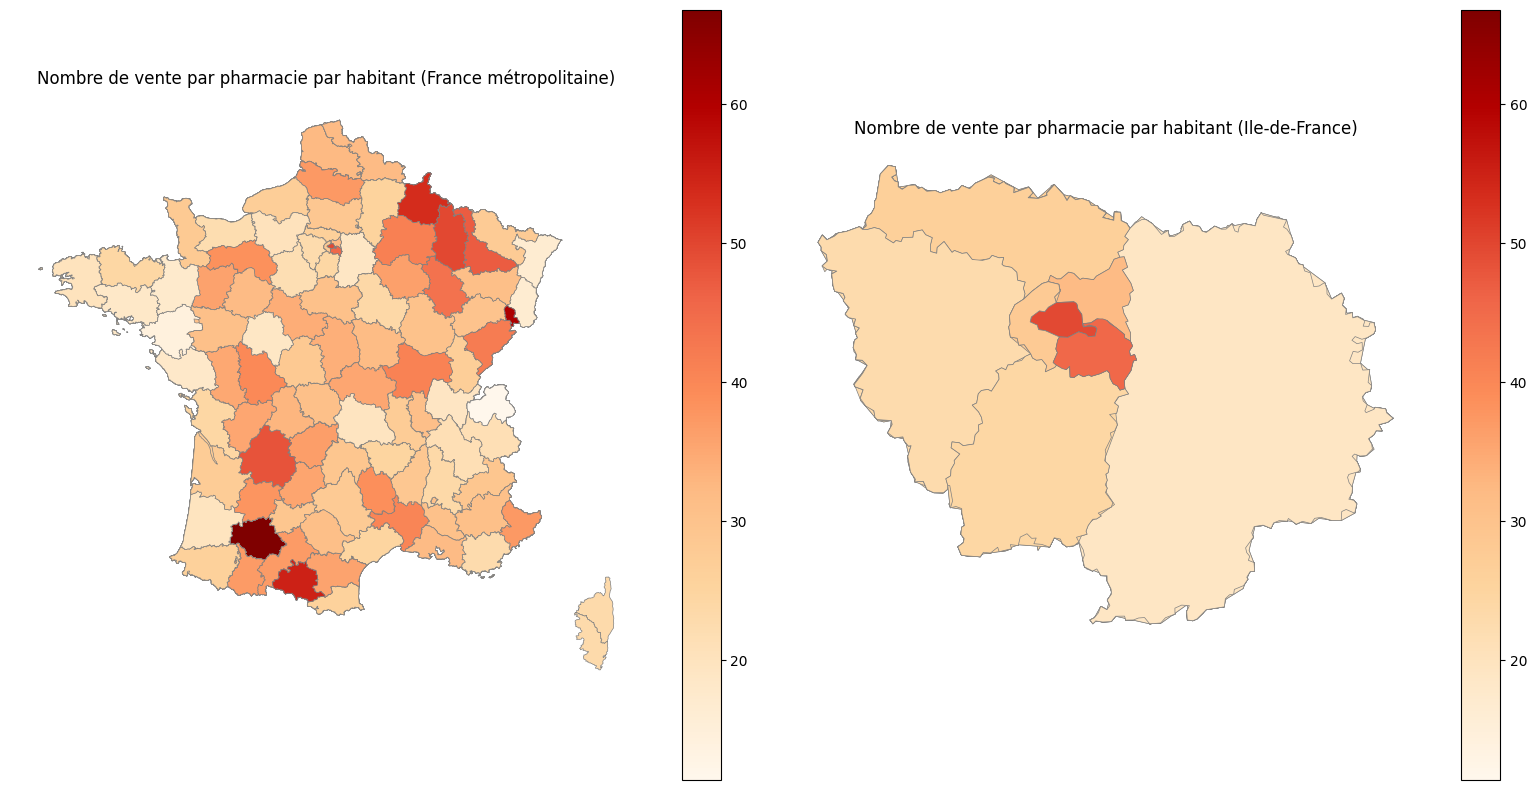

In [ ]:
df_pop_pharma["vente_pharma_pop"] = (df_pop_pharma["pharma_pour_10k"] / df_pop_sales["sales_per_capita"])
df_pop_pharma


gdf9 = (
    gdf_dept
      .merge(df_pop_pharma[['code_dept','vente_pharma_pop']], on="code_dept", how='left')
      .fillna({'vente_pharma_pop': 0})
)
gdf10 = (
    gdf_dept[gdf_dept['code_dept'].isin(CODE_IDF)]
      .merge(df_pop_pharma[['code_dept','vente_pharma_pop']], on="code_dept", how='left')
      .fillna({'vente_pharma_pop': 0})
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
vmin = min(gdf9['vente_pharma_pop'].min(), gdf10['vente_pharma_pop'].min())
vmax = max(gdf9['vente_pharma_pop'].max(), gdf10['vente_pharma_pop'].max())

gdf9.plot(
    column='vente_pharma_pop',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax1,
    vmin=vmin,
    vmax=vmax
)
ax1.set_title("Nombre de vente par pharmacie par habitant (France métropolitaine)")
ax1.axis('off')

gdf10.plot(
    column='vente_pharma_pop',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax2,
    vmin=vmin,
    vmax=vmax
)
ax2.set_title("Nombre de vente par pharmacie par habitant (Ile-de-France)")
ax2.axis('off')


plt.tight_layout()
plt.show()

## Ventes totales 2023 et 2024

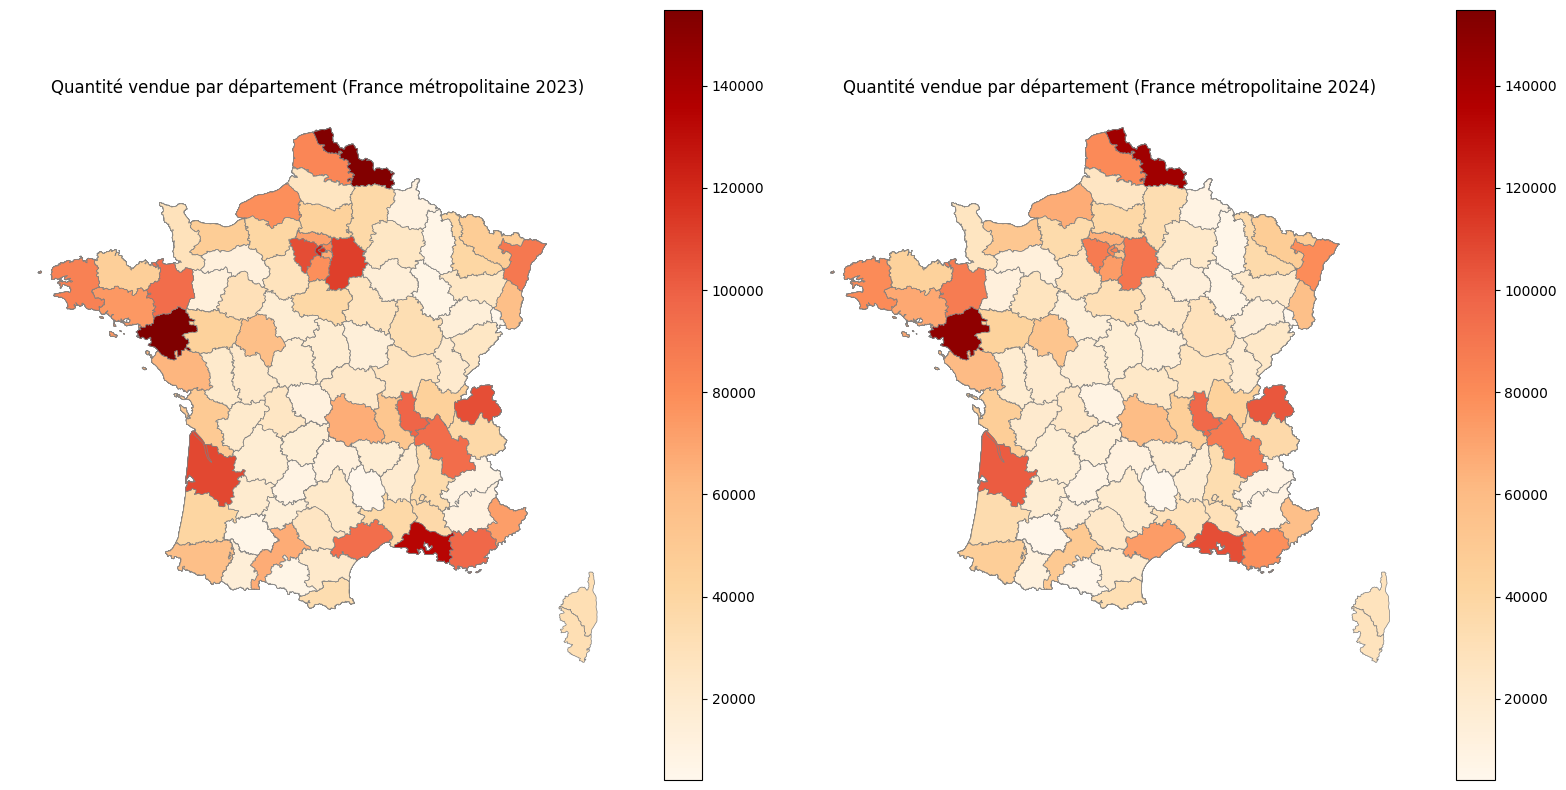

In [ ]:
sales_by_dept2023 = (
    df2023.groupby('code_dept')['qte_facturee']
      .sum()
      .reset_index(name='sales')
)
sales_by_dept2024 = (
    df2024.groupby('code_dept')['qte_facturee']
      .sum()
      .reset_index(name='sales')
)

gdf2023 = (
    gdf_dept
      .merge(sales_by_dept2023, on="code_dept", how='left')
      .fillna({'sales': 0})
)

gdf2024 = (
    gdf_dept
      .merge(sales_by_dept2024, on="code_dept", how='left')
      .fillna({'sales': 0})
)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
vmin = min(gdf2023['sales'].min(), gdf2024['sales'].min())
vmax = max(gdf2023['sales'].max(), gdf2024['sales'].max())

gdf2023.plot(
    column='sales',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax1,
    vmin=vmin,
    vmax=vmax 
)
ax1.set_title("Quantité vendue par département (France métropolitaine 2023)")
ax1.axis('off')

gdf2024.plot(
    column='sales',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax2,
    vmin=vmin,
    vmax=vmax 
)
ax2.set_title("Quantité vendue par département (France métropolitaine 2024)")
ax2.axis('off')


plt.tight_layout()
plt.show()

## Delta vente 2023 - 2024

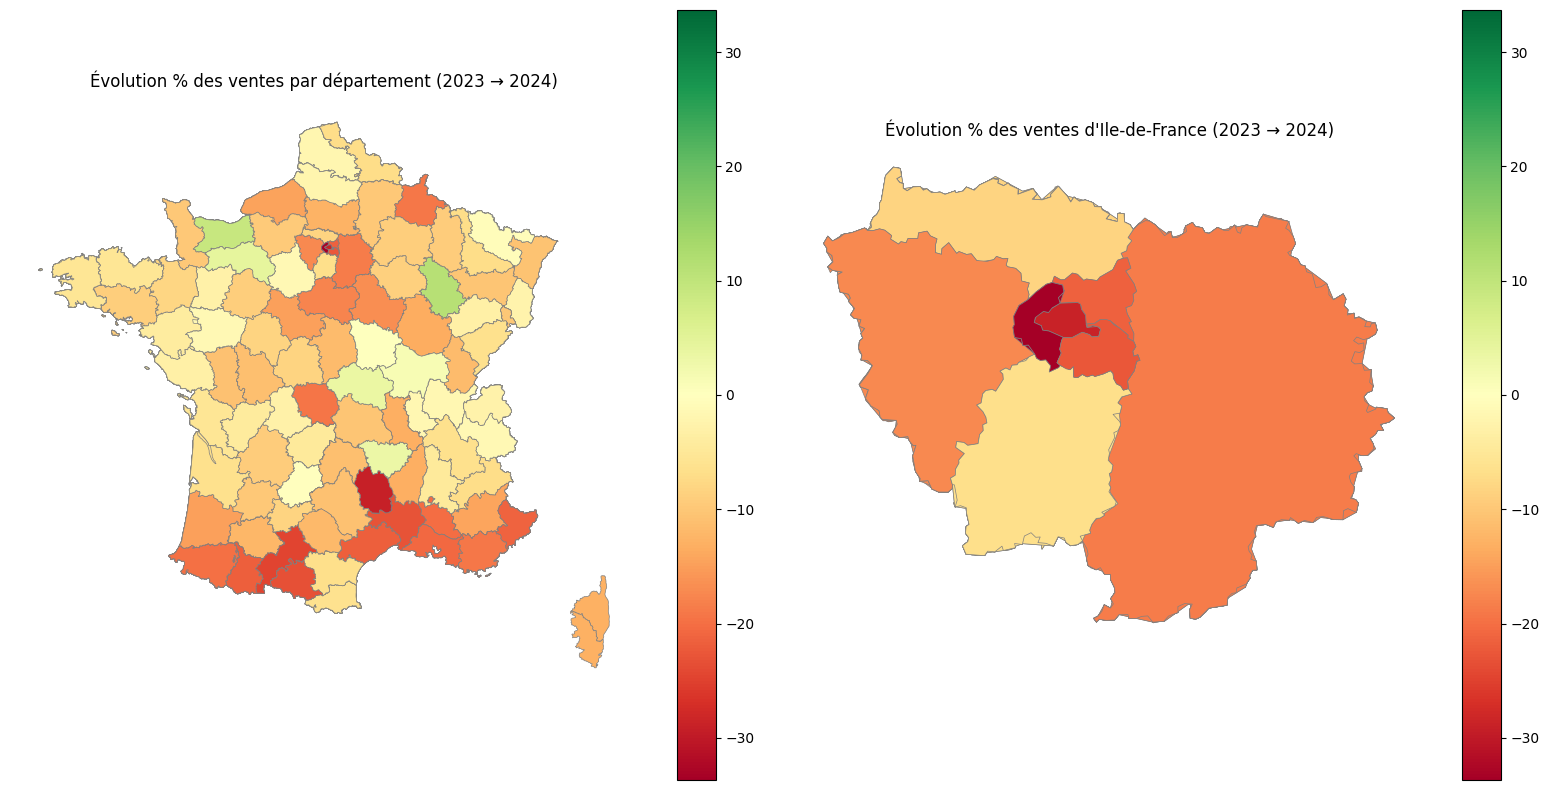

In [ ]:
sales_by_dept2023 = sales_by_dept2023.rename(columns={"sales": "sales2023"})
sales_by_dept2024 = sales_by_dept2024.rename(columns={"sales": "sales2024"})

df_delta_2023_2024 = pd.merge(
    sales_by_dept2023,
    sales_by_dept2024,
    on='code_dept',
    how='outer'
).fillna(0)

df_delta_2023_2024["delta_sales"] = df_delta_2023_2024["sales2024"] - df_delta_2023_2024["sales2023"]
df_delta_2023_2024["%_evolution"] = (df_delta_2023_2024["delta_sales"]/ df_delta_2023_2024["sales2023"]) * 100
df_delta_2023_2024.sort_values(by=["delta_sales"], ascending=False)

gdfdelta = (
    gdf_dept
      .merge(df_delta_2023_2024, on="code_dept", how='left')
      .fillna({'sales2023': 0, 'sales2024': 0, 'delta_sales': 0, '%_evolution': 0})
)

gdfdelta2= (
    gdf_dept[gdf_dept['code_dept'].isin(CODE_IDF)]
      .merge(df_delta_2023_2024, on="code_dept", how='left')
      .fillna({'sales2023': 0, 'sales2024': 0, 'delta_sales': 0, '%_evolution': 0})
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
abs_max = max(abs(gdfdelta["%_evolution"].min()), abs(gdfdelta["%_evolution"].max()))

gdfdelta.plot(
    column='%_evolution',
    cmap='RdYlGn',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax1,
    vmin=-abs_max,
    vmax=abs_max
)
ax1.set_title("Évolution % des ventes par département (2023 → 2024)")
ax1.axis('off')

gdfdelta2.plot(
    column='%_evolution',
    cmap='RdYlGn',
    linewidth=0.5,
    edgecolor='gray',
    legend=True,
    ax=ax2,
    vmin=-abs_max,
    vmax=abs_max
)
ax2.set_title("Évolution % des ventes d'Ile-de-France (2023 → 2024)")
ax2.axis('off')

plt.tight_layout()
plt.show()